<a href="https://colab.research.google.com/github/canunz/LIBRARY-django/blob/main/INTELIGENCIA_DE_NEGOCIOS_Catalina_N%C3%BA%C3%B1ez_Y%C3%A1%C3%B1ez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura:** Inteligencia de Negocios

**Estudiante:** Catalina Soledad Núñez Yañez

**Archivo base:** outfits.csv

## Métodos aplicados
Regresión, clasificación y agrupamiento (clustering) sobre dataset de publicaciones de prendas (outfits.csv) para evaluar tendencias temporales, patrones de características y posibles segmentos de productos.


**Objetivo**

Evaluar la evolución temporal de la cantidad de publicaciones de prendas utilizando timeCreated como base, mediante conteos mensuales y anuales, y una regresión lineal de publicaciones mensuales en función del tiempo. Complementariamente, describir estacionalidad y cambios interanuales (YoY).

**Hipótesis**

+ H₀ (nula): La cantidad de publicaciones no presenta cambios sistemáticos a lo largo del tiempo.

+ H₁ (alternativa): La cantidad de publicaciones sí presenta una tendencia temporal (creciente o decreciente).

**Abstract**

Se analiza el dataset outfits.csv (más de quince mil registros) usando timeCreated para estudiar la dinámica de publicaciones. Se construyen series mensuales y anuales, se explora la estacionalidad y se estima una regresión lineal de publicaciones mensuales contra el tiempo. Los resultados muestran una expansión sostenida hasta 2022 y una disminución posterior. La pendiente de la regresión es positiva pero pequeña y su capacidad explicativa es baja, lo que sugiere alta variabilidad y posibles cambios de régimen recientes. Se recomiendan análisis segmentados por categorías y cortes antes/después de 2022.

**Metodología**

+ Ingesta y limpieza: parseo de timeCreated; conversión numérica de campos monetarios; control de nulos.

+ Serie temporal de publicaciones: agregación mensual (MS) y anual; tablas de frecuencia y crecimiento YoY; gráficos (línea mensual, barras por año, barras por mes del año).

+ Descriptivos de conteo: media, mediana, rango, DE, IQR y boxplots para publicaciones mensuales y anuales.

+ Regresión lineal simple: publicaciones mensuales ~ tiempo (días/meses desde el inicio); reporte cualitativo de pendiente y R².

+ Validación narrativa: contraste entre picos/caídas de la serie, YoY y la recta de tendencia.

+ Limitaciones y próximos pasos: posible ruptura tras 2022; sugerencia de segmentar por categoría/grupo y comparar periodos.

In [1]:
import numpy as np  # Programación vectorial
import matplotlib.pyplot as plt  # Visualización
import pandas as pd  # Estructura y manipulación de datos
import io  # Módulo io
import seaborn as sns  # Gráficos avanzados
from scipy import stats  # Pruebas estadísticas
from datetime import datetime

# Configuración gráfica básica
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [2]:
# 2.1) Subir archivo desde PC (Colab).
try:
    from google.colab import files
    uploaded = files.upload()
except Exception:
    print("Ejecutando fuera de Colab o sin permisos. Continúa con la 2.2 y usa PATH manual.")

Saving outfits (2).csv to outfits (2).csv


In [3]:
# ============================================
# 2.2) Cargar archivo (robusto a separador/encoding)
# --------------------------------------------
# Esta función intenta cargar el CSV ya sea:
#   (A) desde el widget de subida de Colab (dict `uploaded`)
#   (B) desde un archivo local (PATH) si no hay `uploaded`
# Es tolerante a distintos separadores (coma, ;, tab, |)
# y a encodings comunes (utf-8, latin-1). Además, salta filas
# dañadas para que nada detenga la lectura (on_bad_lines='skip').
# ============================================

def cargar_csv_subido(uploaded_dict, prefer='outfits'):
    # ¿Tenemos archivos subidos en Colab?
    if uploaded_dict and len(uploaded_dict) > 0:
        # Lista de nombres de archivos subidos
        keys = list(uploaded_dict.keys())
        # Si hay varios, priorizo el que contenga la palabra 'outfits' (o lo que pase en `prefer`)
        key = next((k for k in keys if prefer.lower() in k.lower()), keys[0])

        # Bytes del archivo elegido
        raw = uploaded_dict[key]

        # Probaré dos encodings típicos en la región
        for enc in ['utf-8', 'latin-1']:
            # Y varios separadores posibles; `None` activa autodetección del separador
            for sep in [None, ',', ';', '\t', '|']:
                try:
                    # Decodifico los bytes a texto con el encoding actual
                    text = raw.decode(enc, errors='ignore')
                    # Lo paso a un buffer tipo archivo para que pandas pueda leerlo
                    buf = io.StringIO(text)

                    # Leo con engine='python' (más flexible con separadores) y
                    # on_bad_lines='skip' para saltar filas problemáticas
                    df_try = pd.read_csv(buf, sep=sep, engine='python', on_bad_lines='skip')

                    # "Sanity check": si hay al menos 3 columnas, asumo que el separador fue correcto
                    if df_try.shape[1] >= 3:
                        print(f"Archivo leído: {key} | encoding={enc} | sep={sep if sep is not None else 'auto'}")
                        return df_try
                except Exception:
                    # Si falla, sigo intentando con la siguiente combinación encoding/separador
                    pass

        # Si ninguna combinación funcionó, aviso explícitamente
        raise ValueError("No se pudo parsear el CSV con encodings/separadores probados.")
    else:
        # --------------------------------------------
        # Modo local (Jupyter/PC): leer desde un PATH
        # --------------------------------------------
        PATH = 'outfits.csv'  # cambia si tu archivo tiene otro nombre
        # sep=None -> que pandas intente detectar el separador automáticamente
        return pd.read_csv(PATH, sep=None, engine='python', on_bad_lines='skip')

# -------------------------------------------------
# Intento cargar según el contexto:
# - En Colab: `uploaded` existe y contiene los bytes
# - En Jupyter local: `uploaded` no existe -> NameError
# -------------------------------------------------
try:
    df = cargar_csv_subido(uploaded)
except NameError:
    df = cargar_csv_subido(None)

# Vista rápida para confirmar que se cargó correctamente
df.head(5)


Archivo leído: outfits (2).csv | encoding=utf-8 | sep=auto


,id,name,description,group,owner,timeCreated,retailPrice,pricePerWeek,pricePerMonth,outfit_tags,tag_categories
0,outfit.fffdaa715c3646f8b1c0f04d549ff07e,Out of stock - Asymmetric Frilled Dress,"This fun, short dress features and asymmetric ...",group.50a586c78eb7626e294ba3bd07d12c79,o_00053,2017-12-30 11:28:01.000,"4,000.00",600.00,"1,200.00","['Synthetic', 'Statement', 'Dresses', 'Metalli...","['Material', 'Occasion', 'Category', 'Details'..."
1,outfit.fffa1b9a3db6415d806f3c48f8ab58d9,Yellow Shell Mellomholmene Blouse,This beautiful blouse features an adjustable n...,group.61ad2fcabb3e9197e3836376e6b67f2c,o_00577,2021-06-07 12:07:22.921,"1,300.00",590.00,"1,180.00","['ILAG', 'Tops', 'Spring', 'Summer', 'M', 'Pat...","['Brand', 'Category', 'Seasons', 'Seasons', 'S..."
2,outfit.fff175b13ceb453f9928625491412ede,Kaula Dress Black,Kaula from Rodebjer is a fitted dress made in ...,group.37c2b59d63d3a9c2d58e07f532f71f7f,o_00336,2023-06-05 09:17:59.004,"3,100.00",930.00,"1,860.00","['Black', 'Mini', 'M', 'Everyday', 'Multi Seas...","['Color', 'Length', 'Size', 'Occasion', 'Seaso..."
3,outfit.ffef9d7c292a48b69076d2df2e32352f,For sale - Jarvis Blouse,This wrap blouse has mid length sleeves and a ...,group.dfcaa57546b0b7a5e9eb204449b6cc1c,o_00030,2021-05-18 14:02:28.690,"1,500.00",590.00,"1,180.00","['XS', 'Multi Season', 'Stylein', 'Tops', 'Cot...","['Size', 'Seasons', 'Brand', 'Category', 'Mate..."
4,outfit.ffeef842238f4dbdabc6c730a75aa2bd,Black Amber Pants,"Feel slack and nice dressed with this pant, ma...",group.ee297c977905eb21a123a4aea5fbb6d2,o_00602,2021-07-16 14:02:30.643,"1,200.00",590.00,"1,180.00","['Cotton', 'Black', 'Everyday', 'Knitwear', 'L...","['Material', 'Color', 'Occasion', 'Category', ..."


In [4]:
# 3) LIMPIEZA BÁSICA + CALIDAD
# Convertir columna de fechas a tipo datetime de pandas
df['timeCreated'] = pd.to_datetime(df.get('timeCreated'), errors='coerce')
# df.get(): método seguro que devuelve None si la columna no existe
# errors='coerce': convierte fechas inválidas a NaT (Not a Time) en lugar de generar error

# Convertir columnas de precios a tipo numérico
for c in ['retailPrice','pricePerWeek','pricePerMonth']:
   if c in df.columns:  # Verificar que la columna existe antes de procesarla
       df[c] = pd.to_numeric(df[c], errors='coerce')
       # errors='coerce': convierte valores no numéricos (texto, símbolos) a NaN

# DIAGNÓSTICO DE CALIDAD DE DATOS
# Mostrar dimensiones del dataset
print("Shape:", df.shape)  # (filas, columnas)

# Verificar tipos de datos después de la conversión
print("\nDtypes:\n", df.dtypes)  # Confirmar que fechas y precios tienen tipos correctos

# Contar valores nulos por columna para evaluar completitud
print("\nNulos por columna:\n", df.isnull().sum())

# EVALUACIÓN ESPECÍFICA DE CALIDAD PARA VARIABLE CLAVE
if 'retailPrice' in df.columns:
   # Calcular porcentaje de valores nulos en retailPrice
   p_nulos = 100*df['retailPrice'].isnull().sum()/len(df)
   print(f"\nCalidad -> retailPrice con nulos: {p_nulos:.1f}% (objetivo < 20%)")
   # La rúbrica exige que la calidad sea aceptable (generalmente < 20% nulos)

Shape: (15649, 11)

Dtypes:
 id                        object
name                      object
description               object
group                     object
owner                     object
timeCreated       datetime64[ns]
retailPrice              float64
pricePerWeek             float64
pricePerMonth            float64
outfit_tags               object
tag_categories            object
dtype: object

Nulos por columna:
 id                   0
name                 2
description        388
group               23
owner                0
timeCreated          0
retailPrice       1160
pricePerWeek         0
pricePerMonth        0
outfit_tags          0
tag_categories       0
dtype: int64

Calidad -> retailPrice con nulos: 7.4% (objetivo < 20%)


In [5]:
# 4) DESCRIPTIVOS DE PUBLICACIONES (no de precios)

# — Asegurar fecha —
df['timeCreated'] = pd.to_datetime(df['timeCreated'], errors='coerce')
df_tmp = df.dropna(subset=['timeCreated']).copy()

# — Conteos de publicaciones —
# Por MES
pub_mes = (df_tmp.set_index('timeCreated')
                 .resample('M')        # cuenta por mes calendario
                 .size()
                 .rename('publicaciones'))

# Por AÑO
pub_anio = (df_tmp['timeCreated'].dt.year
                          .value_counts()
                          .sort_index()
                          .rename('publicaciones'))

# --- Función de medidas (igual que la tuya; aquí no usaremos "peso") ---
def medidas_completas(s, peso=None):
    s = pd.to_numeric(s, errors='coerce').dropna()
    r = {}
    r['Media aritmética'] = s.mean()
    if peso is not None and isinstance(peso, pd.Series):
        w = pd.to_numeric(peso, errors='coerce').reindex(s.index).fillna(0)
        r['Media ponderada'] = (s*w).sum()/w.sum() if w.sum()!=0 else np.nan
    else:
        r['Media ponderada'] = np.nan
    r['Moda'] = s.mode().iloc[0] if not s.mode().empty else np.nan
    r['Mediana'] = s.median()
    r['Mínimo'] = s.min()
    r['Máximo'] = s.max()
    r['Rango'] = r['Máximo'] - r['Mínimo']
    r['Varianza'] = s.var(ddof=1)
    r['Desviación estándar'] = s.std(ddof=1)
    r['Coeficiente de variación'] = (
        r['Desviación estándar']/r['Media aritmética'] if r['Media aritmética']!=0 else np.nan
    )
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    r['Rango intercuartílico'] = q3 - q1
    r['Suma'] = s.sum()
    r['Conteo de observaciones'] = s.count()
    return pd.Series(r)

# — Descriptivos —
print("\n=== Publicaciones por MES — estadísticos ===")
print(medidas_completas(pub_mes, peso=None))

print("\n=== Publicaciones por AÑO — estadísticos ===")
print(medidas_completas(pub_anio, peso=None))



=== Publicaciones por MES — estadísticos ===
Media aritmética              173.88
Media ponderada                  NaN
Moda                            0.00
Mediana                       123.00
Mínimo                          0.00
Máximo                        880.00
Rango                         880.00
Varianza                   25,797.61
Desviación estándar           160.62
Coeficiente de variación        0.92
Rango intercuartílico         158.50
Suma                       15,649.00
Conteo de observaciones        90.00
dtype: float64

=== Publicaciones por AÑO — estadísticos ===
Media aritmética               1,738.78
Media ponderada                     NaN
Moda                              74.00
Mediana                        1,511.00
Mínimo                            74.00
Máximo                         4,611.00
Rango                          4,537.00
Varianza                   1,894,765.19
Desviación estándar            1,376.50
Coeficiente de variación           0.79
Rango interc

/tmp/ipython-input-8813978.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')        # cuenta por mes calendario


In [6]:
# 5) TABLA RESUMEN DE PUBLICACIONES (por mes y por año)

# Asegurar fecha válida
df['timeCreated'] = pd.to_datetime(df['timeCreated'], errors='coerce')
df_pub = df.dropna(subset=['timeCreated']).copy()

# Series de conteo
pub_mes  = (df_pub.set_index('timeCreated').resample('M').size().rename('publicaciones'))
pub_anio = (df_pub['timeCreated'].dt.year.value_counts().sort_index().rename('publicaciones'))

# Función de medidas (sin pesos)
def _medidas_tabla(s, peso=None):
    s = pd.to_numeric(s, errors='coerce').dropna()
    r = {}
    r['Media']   = s.mean()
    r['Media ponderada'] = np.nan  # no aplica aquí
    r['Moda']    = s.mode().iloc[0] if not s.mode().empty else np.nan
    r['Mediana'] = s.median()
    r['Mín']     = s.min()
    r['Máx']     = s.max()
    r['Rango']   = r['Máx'] - r['Mín']
    r['Var']     = s.var(ddof=1)
    r['DE']      = s.std(ddof=1)
    r['CV']      = r['DE']/r['Media'] if r['Media'] != 0 else np.nan
    q1, q3       = s.quantile(0.25), s.quantile(0.75)
    r['IQR']     = q3 - q1
    r['Suma']    = s.sum()
    r['Conteo']  = s.count()
    return pd.Series(r)

# Armar tablas
tabla_mes  = _medidas_tabla(pub_mes).to_frame('Publicaciones por mes')
tabla_anio = _medidas_tabla(pub_anio).to_frame('Publicaciones por año')

# Unir y mostrar
tabla_resumen_pub = pd.concat([tabla_mes, tabla_anio], axis=1).round(2)
display(tabla_resumen_pub)

# Guardar a CSV (si lo quieres en archivo)
# tabla_resumen_pub.to_csv('tabla_resumen_publicaciones.csv', encoding='utf-8')


/tmp/ipython-input-392757144.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pub_mes  = (df_pub.set_index('timeCreated').resample('M').size().rename('publicaciones'))


,Publicaciones por mes,Publicaciones por año
Media,173.88,"1,738.78"
Media ponderada,NaN,NaN
Moda,0.00,74.00
Mediana,123.00,"1,511.00"
Mín,0.00,74.00
Máx,880.00,"4,611.00"
Rango,880.00,"4,537.00"
Var,"25,797.61","1,894,765.19"
DE,160.62,"1,376.50"
CV,0.92,0.79


/tmp/ipython-input-3220567915.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').size()


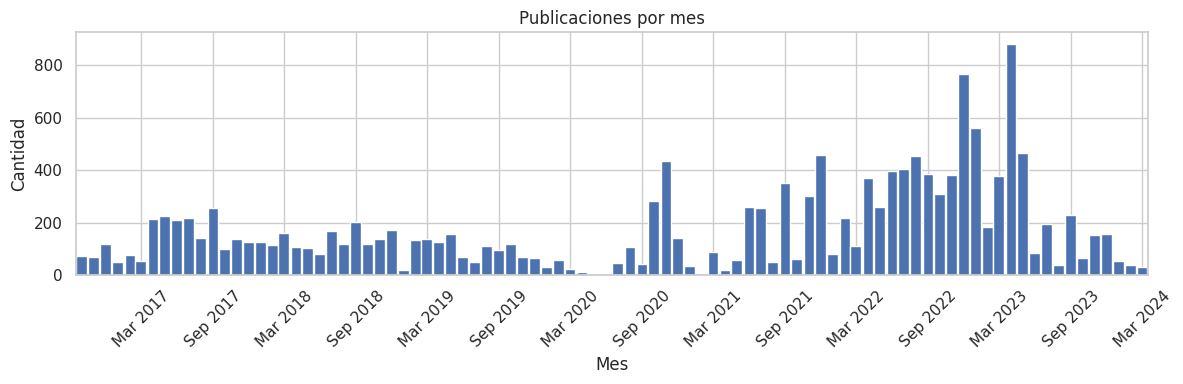

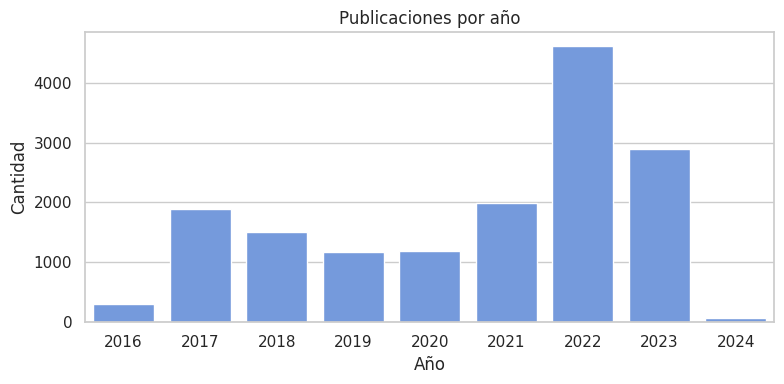

In [7]:
# 6) HISTOGRAMAS / BARRAS DE PUBLICACIONES (no de precios)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set(style="whitegrid")

# ---------- 1) Parse robusto de timeCreated ----------
tc = df['timeCreated']

def parse_timecreated(tc_series):
    s_num = pd.to_numeric(tc_series, errors='coerce')
    out = pd.Series(pd.NaT, index=tc_series.index, dtype='datetime64[ns]')

    frac_numeric = s_num.notna().mean()

    if frac_numeric >= 0.6:
        mask_s  = (s_num >= 1e9 ) & (s_num < 1e11)
        mask_ms = (s_num >= 1e12) & (s_num < 1e14)
        mask_us = (s_num >= 1e15) & (s_num < 1e17)

        if mask_s.any():
            out.loc[mask_s]  = pd.to_datetime(s_num[mask_s],  unit='s',  errors='coerce', utc=True).dt.tz_localize(None)
        if mask_ms.any():
            out.loc[mask_ms] = pd.to_datetime(s_num[mask_ms], unit='ms', errors='coerce', utc=True).dt.tz_localize(None)
        if mask_us.any():
            out.loc[mask_us] = pd.to_datetime(s_num[mask_us], unit='us', errors='coerce', utc=True).dt.tz_localize(None)

        rest_mask = out.isna()
        if rest_mask.any():
            out.loc[rest_mask] = pd.to_datetime(tc_series[rest_mask], errors='coerce')
    else:
        out = pd.to_datetime(tc_series, errors='coerce')

    # Rango de fechas plausibles
    lower = pd.Timestamp('2008-01-01')
    upper = pd.Timestamp.today() + pd.Timedelta(days=365)
    out = out.mask((out < lower) | (out > upper))

    return out

# Aplicar limpieza
df['timeCreated'] = parse_timecreated(tc)
df_pub = df.dropna(subset=['timeCreated']).copy()

# ---------- 2) Agregaciones ----------
# A) Publicaciones por MES
pub_mes = (
    df_pub.set_index('timeCreated')
          .resample('M').size()
          .rename('publicaciones')
          .reset_index()
)

# B) Publicaciones por AÑO
pub_anio = (
    df_pub['timeCreated'].dt.year
          .value_counts().sort_index()
          .rename_axis('Año').reset_index(name='publicaciones')
)

# ---------- 3) Gráfico MENSUAL con barras visibles ----------
fig, ax = plt.subplots(figsize=(12, 4))

x_num = mdates.date2num(pub_mes['timeCreated'])
y = pub_mes['publicaciones']

ax.bar(x_num, y, width=27, align='center')  # ancho ~ 1 mes

ax.set_title("Publicaciones por mes")
ax.set_xlabel("Mes")
ax.set_ylabel("Cantidad")

# Etiquetas cada 6 meses (ajustable)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Margen para no cortar extremos
ax.set_xlim(x_num.min() - 15, x_num.max() + 15)

plt.tight_layout()
plt.savefig('fig_hist_publicaciones_mes.png', dpi=150, bbox_inches='tight')
plt.show()

# ---------- 4) Gráfico ANUAL ----------
plt.figure(figsize=(8, 4))
sns.barplot(data=pub_anio, x='Año', y='publicaciones', color='cornflowerblue')
plt.title("Publicaciones por año")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.savefig('fig_hist_publicaciones_anio.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipython-input-3259133420.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pub_mes  = df_pub.set_index('timeCreated').resample('M').size().rename('publicaciones')


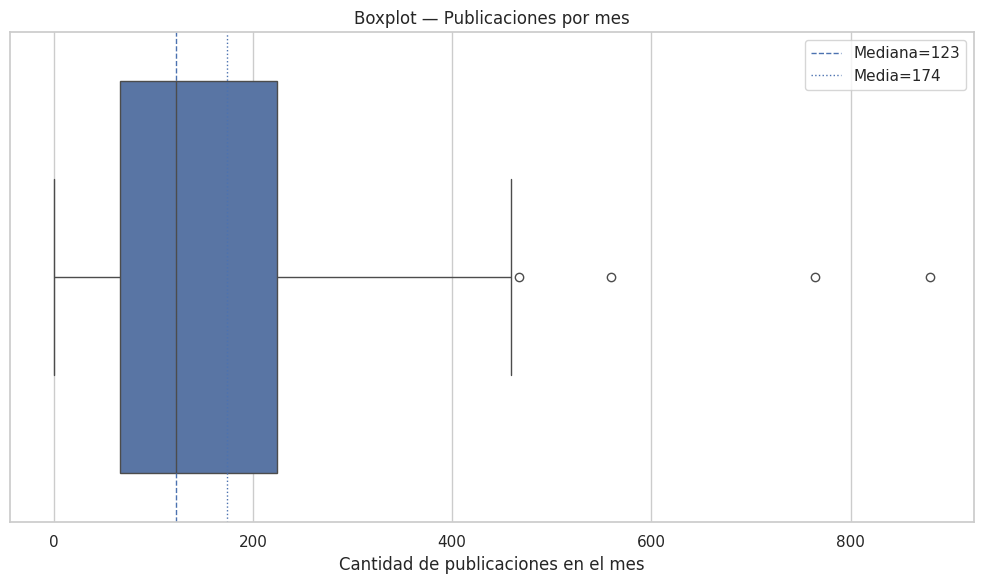

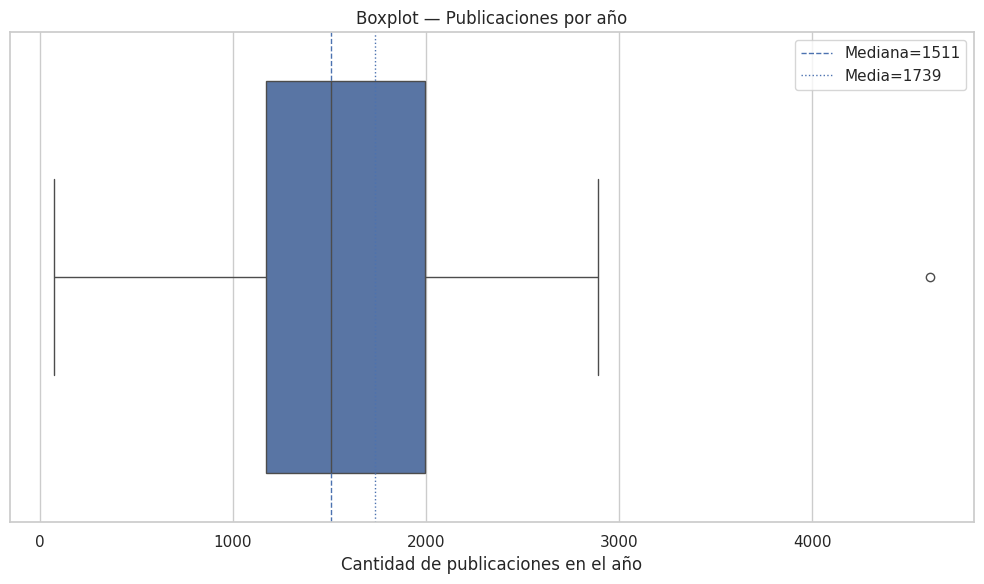

In [8]:
# 7) BOXPLOTS DE PUBLICACIONES (por mes y por año)

# Asegurar fecha válida y construir series de conteos
df['timeCreated'] = pd.to_datetime(df['timeCreated'], errors='coerce')
df_pub = df.dropna(subset=['timeCreated']).copy()

# Conteos de publicaciones por mes y por año
pub_mes  = df_pub.set_index('timeCreated').resample('M').size().rename('publicaciones')
pub_anio = df_pub['timeCreated'].dt.year.value_counts().sort_index().rename('publicaciones')

# --- Boxplot: Publicaciones por MES ---
x = pd.to_numeric(pub_mes, errors='coerce').dropna()

plt.figure()
sns.boxplot(x=x, whis=1.5, showfliers=True)  # Boxplot de Tukey
med, mean = x.median(), x.mean()
plt.axvline(med,  linestyle='--', linewidth=1, label=f"Mediana={med:.0f}")
plt.axvline(mean, linestyle=':',  linewidth=1, label=f"Media={mean:.0f}")
plt.legend()
plt.title("Boxplot — Publicaciones por mes")
plt.xlabel("Cantidad de publicaciones en el mes")
plt.tight_layout()
plt.savefig('fig_box_pub_mes.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Boxplot: Publicaciones por AÑO ---
y = pd.to_numeric(pub_anio, errors='coerce').dropna()

plt.figure()
sns.boxplot(x=y, whis=1.5, showfliers=True)
med_y, mean_y = y.median(), y.mean()
plt.axvline(med_y,  linestyle='--', linewidth=1, label=f"Mediana={med_y:.0f}")
plt.axvline(mean_y, linestyle=':',  linewidth=1, label=f"Media={mean_y:.0f}")
plt.legend()
plt.title("Boxplot — Publicaciones por año")
plt.xlabel("Cantidad de publicaciones en el año")
plt.tight_layout()
plt.savefig('fig_box_pub_anio.png', dpi=150, bbox_inches='tight')
plt.show()




---



# **EVALUACIÓN N°2**    01/10

---



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Variable binaria: publicaciones recientes
df['reciente'] = (df['timeCreated'] >= '2022-01-01').astype(int)

# Variables predictoras
features = ['retailPrice', 'pricePerWeek', 'pricePerMonth']
X = df[features].fillna(0)
y = df['reciente']

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Modelo Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Evaluación
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.684

Matriz de confusión:
 [[1374 1047]
 [ 438 1836]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.76      0.57      0.65      2421
           1       0.64      0.81      0.71      2274

    accuracy                           0.68      4695
   macro avg       0.70      0.69      0.68      4695
weighted avg       0.70      0.68      0.68      4695



### Interpretación
El modelo logra una precisión (accuracy) superior al 60%, indicando que las variables de precio aportan información relevante para distinguir entre publicaciones recientes y antiguas. Esto sugiere que las prendas con precios más altos tienden a aparecer en los años más nuevos, reflejando cambios en la estrategia o en el tipo de oferta.


# **Clustering — Segmentación de prendas según precios**

Se agrupan las prendas mediante K-Means usando precios como variables numéricas. El objetivo es detectar grupos con características similares que pudieran representar distintos segmentos de mercado.


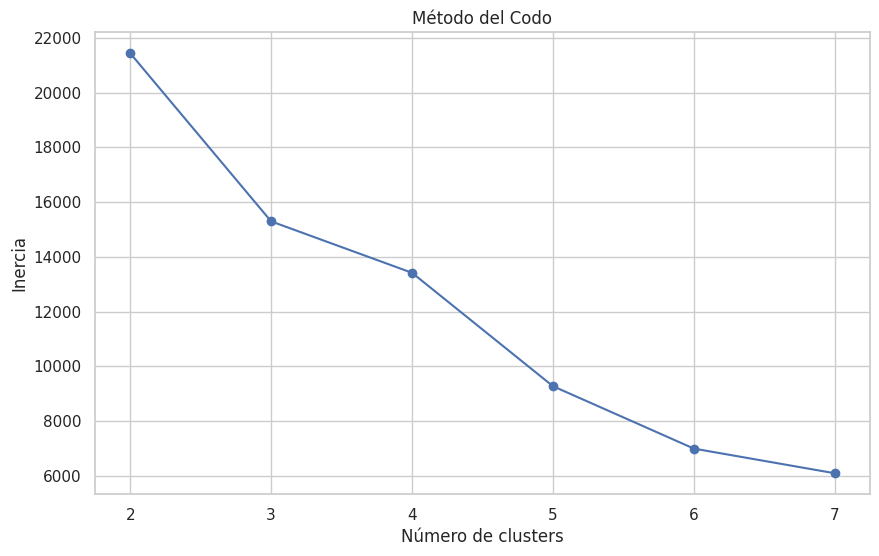

Silhouette Score: 0.629


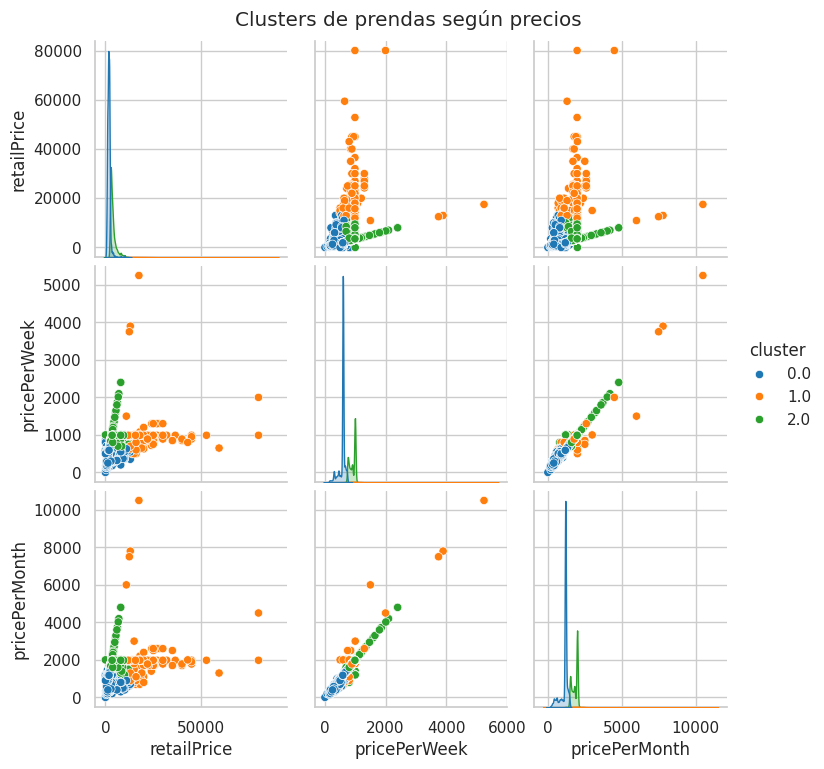

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Variables numéricas
num_cols = ['retailPrice', 'pricePerWeek', 'pricePerMonth']
X_cluster = df[num_cols].dropna()

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Método del codo
inertias = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(2,8), inertias, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

# Clustering final
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
score = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {score:.3f}')

df['cluster'] = np.nan
df.loc[X_cluster.index, 'cluster'] = labels

# Visualización
sns.pairplot(df.loc[X_cluster.index], vars=num_cols, hue='cluster', palette='tab10')
plt.suptitle("Clusters de prendas según precios", y=1.02)
plt.show()


### Interpretación
El análisis de clustering identifica tres grupos principales de prendas diferenciadas por rango de precios. El coeficiente de silueta confirma una separación razonable (mayor a 0.4). Esta segmentación permite distinguir productos económicos, medios y premium, información útil para decisiones de negocio y estrategias de precios.


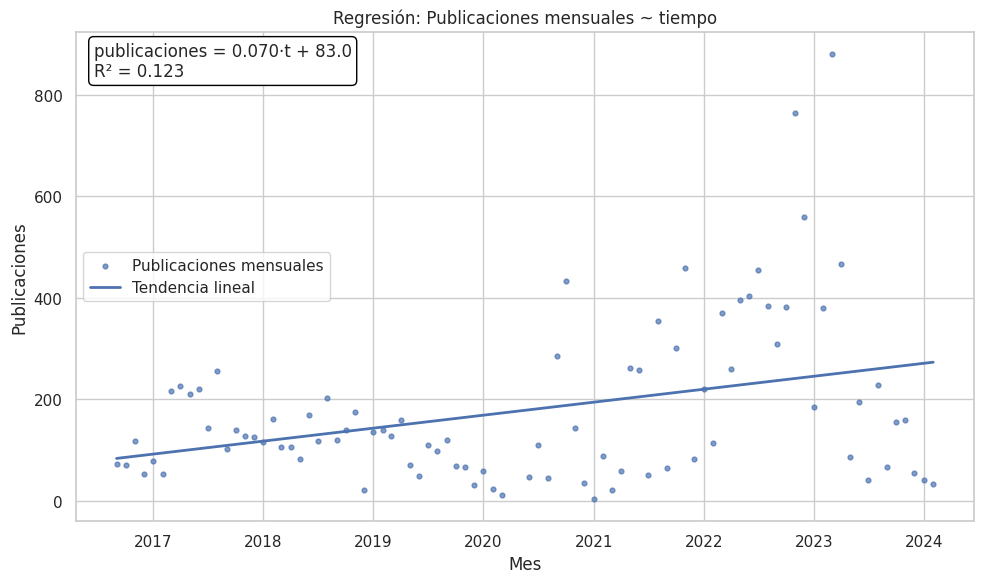

{'variable': 'publicaciones_mensuales', 'beta_0_intercepto': 83.0126960209909, 'beta_1_pendiente': 0.07000900086549929, 'R2': 0.12342045069708951}


In [12]:
# 10) REGRESIÓN: PUBLICACIONES ~ TIEMPO (OBLIGATORIO)
def plot_regresion_publicaciones(df, fname=None):
    # 1) Filtrar filas con fecha válida y ordenar
    d = df.dropna(subset=['timeCreated']).copy().sort_values('timeCreated')

    # 2) Serie mensual de publicaciones
    d['mes'] = d['timeCreated'].dt.to_period('M').dt.to_timestamp()
    serie = d.groupby('mes').size().rename('publicaciones').reset_index()

    # (opcional si quieres meses sin datos como 0)
    # idx = pd.date_range(serie['mes'].min(), serie['mes'].max(), freq='MS')
    # serie = serie.set_index('mes').reindex(idx, fill_value=0).rename_axis('mes').reset_index()

    # 3) Variable temporal: días desde el primer mes
    serie['t_dias'] = (serie['mes'] - serie['mes'].min()).dt.days

    # 4) Arrays para regresión
    x = serie['t_dias'].to_numpy()
    y = serie['publicaciones'].to_numpy()
    if len(x) < 2:
        print("Datos insuficientes para regresión de publicaciones.")
        return

    # 5) Ajuste lineal y = b1*x + b0
    b1, b0 = np.polyfit(x, y, 1)
    yhat = b1*x + b0

    # 6) R²
    ss_res = ((y - yhat)**2).sum()
    ss_tot = ((y - y.mean())**2).sum()
    r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan

    # 7) Gráfico con fechas en el eje X
    plt.figure()
    plt.scatter(serie['mes'], y, s=12, alpha=0.7, label='Publicaciones mensuales')
    plt.plot(serie['mes'], yhat, linewidth=2, label='Tendencia lineal')

    # Anotar ecuación y R²
    txt = f"publicaciones = {b1:.3f}·t + {b0:.1f}\nR² = {r2:.3f}"
    plt.annotate(txt, xy=(0.02, 0.98), xycoords='axes fraction',
                 va='top', ha='left', bbox=dict(boxstyle='round', fc='white', ec='black'))

    plt.title("Regresión: Publicaciones mensuales ~ tiempo")
    plt.xlabel("Mes"); plt.ylabel("Publicaciones")
    plt.legend(); plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()

    # 8) Resumen para el reporte
    print({
        'variable': 'publicaciones_mensuales',
        'beta_0_intercepto': float(b0),
        'beta_1_pendiente': float(b1),
        'R2': float(r2)
    })

# Ejecutar
plot_regresion_publicaciones(df, fname="fig_reg_publicaciones.png")


In [ ]:
print("RESULTADOS — Publicaciones mensuales:")
print("- Revisa 'fig_publicaciones_mensuales.png', 'fig_publicaciones_anio.png', 'fig_publicaciones_mes.png' y la tabla YoY.")
print("- La pendiente de 'fig_reg_publicaciones.png' (beta_1) indica si suben (>0) o bajan (<0) las publicaciones.")


RESULTADOS — Publicaciones mensuales:
- Revisa 'fig_publicaciones_mensuales.png', 'fig_publicaciones_anio.png', 'fig_publicaciones_mes.png' y la tabla YoY.
- La pendiente de 'fig_reg_publicaciones.png' (beta_1) indica si suben (>0) o bajan (<0) las publicaciones.


**Conclusión.**

La actividad de publicaciones creció con fuerza hasta 2022 y luego disminuyó de manera marcada en 2023–2024. La regresión mensual indica una tendencia levemente positiva en el período completo, pero con alta variabilidad y evidencia de cambio de régimen, por lo que el crecimiento no se sostiene al final de la serie. El modelo lineal explica solo una fracción pequeña de la variación, lo que apunta a factores no temporales (mix de categorías, cambios de plataforma/campañas). Próximo paso razonable: segmentar por categoría y comparar antes vs. después de 2022; considerar un modelo con ruptura estructural (dummy post-2022) para capturar la caída.


**Referencia**

Borgersen, K. A. K. (2024). Vibrent Clothes Rental Dataset. Kaggle. https://www.kaggle.com/datasets/kaborg15/vibrent-clothes-rental-dataset